# Objective
## Predict the winner of the IPL 2025 Final between two teams 

## ✅ STEP-BY-STEP IPL MATCH WINNER PREDICTION PIPELINE 

### 🏁 STEP 1: Data Preparation & Feature Engineering

**Tasks:**
- Loaded `matches.csv` and `deliveries.csv`, merged on `match_id`
- Aggregated ball-level data into match-level statistics
- Engineered match-level features for both teams:
  - `team1_total_runs`, `team2_total_runs`
  - `team1_wickets_lost`, `team2_wickets_lost`
  - `team1_powerplay_runs`, `team2_powerplay_runs`
- Created strategic derived features:
  - `toss_win_equals_match_win`: whether toss winner won the match
  - `net_run_diff`: `team1_total_runs` − `team2_total_runs`
  - `wicket_diff`: `team2_wickets_lost` − `team1_wickets_lost`

### 📊 STEP 2: Exploratory Data Analysis (EDA)

**Tasks:**
- Visualized:
  - Toss winner vs match winner correlation
  - Feature distributions (e.g., powerplay runs, total runs)
  - Team-wise win frequencies
- Performed basic checks for feature relevance using correlation and intuition

### 🧹 STEP 3: Feature Selection & Preprocessing

**Tasks:**
- Final selected features included:
  - `team1`, `team2`, `venue`, `toss_winner`, `toss_decision`
  - `team1_total_runs`, `team1_wickets_lost`, `team1_powerplay_runs`
  - `team2_total_runs`, `team2_wickets_lost`, `team2_powerplay_runs`
  - `net_run_diff`, `wicket_diff`, `toss_win_equals_match_win`
- Applied Label Encoding to categorical features using `LabelEncoder`
- Split into train/validation sets
- Final feature matrix: `X`, target: `y` (encoded winner)

### 🤖 STEP 4: Model Training & Validation

**Tasks:**
- Trained multiple classifiers:
  - Logistic Regression, Random Forest, and **XGBoost (best performing)**
- Tuned hyperparameters using `GridSearchCV` on XGBoost
- Evaluated using:
  - Accuracy, Precision, Recall, F1-Score
- Best model (XGBoost) achieved:
  - **Validation Accuracy: ~92.36%**
  - High precision and recall across all teams
- Used `predict_proba()` to extract probability scores (confidence)

### 🔮 STEP 5: 2025 Match Simulation & Prediction

**Tasks:**
- Defined `simulate_match_input()` to synthesize realistic test inputs from historical averages
  - Fetches average values for runs, wickets lost, and powerplay performance for each team
- Constructed new match instance with:
  - `team1`, `team2`, `venue` and generated feature columns
  - Manually added `net_run_diff`, `wicket_diff`
- Applied the full model pipeline to predict outcome
  - `predict()` gives winner (encoded)
  - `predict_proba()` gives **confidence for each class**
- Decoded and printed the predicted winner
  - Example: 🏏 **Predicted Winner: Punjab Kings** with confidence **96.6%**



### Importing Libraries

In [1]:
!pip install xgboost

/Users/ananyasingh/.zshenv:1: /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home not found

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import shap
import joblib

### Importing the datasets


In [3]:
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

In [4]:
deliveries


,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [5]:
deliveries.describe()

,match_id,inning,over,ball,batsman_runs,extra_runs,total_runs,is_wicket
count,2.609200e+05,260920.000000,260920.000000,260920.000000,260920.000000,260920.000000,260920.000000,260920.000000
mean,9.070665e+05,1.483531,9.197677,3.624486,1.265001,0.067806,1.332807,0.049632
std,3.679913e+05,0.502643,5.683484,1.814920,1.639298,0.343265,1.626416,0.217184
min,3.359820e+05,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.483340e+05,1.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,9.809670e+05,1.000000,9.000000,4.000000,1.000000,0.000000,1.000000,0.000000
75%,1.254066e+06,2.000000,14.000000,5.000000,1.000000,0.000000,1.000000,0.000000
max,1.426312e+06,6.000000,19.000000,11.000000,6.000000,7.000000,7.000000,1.000000


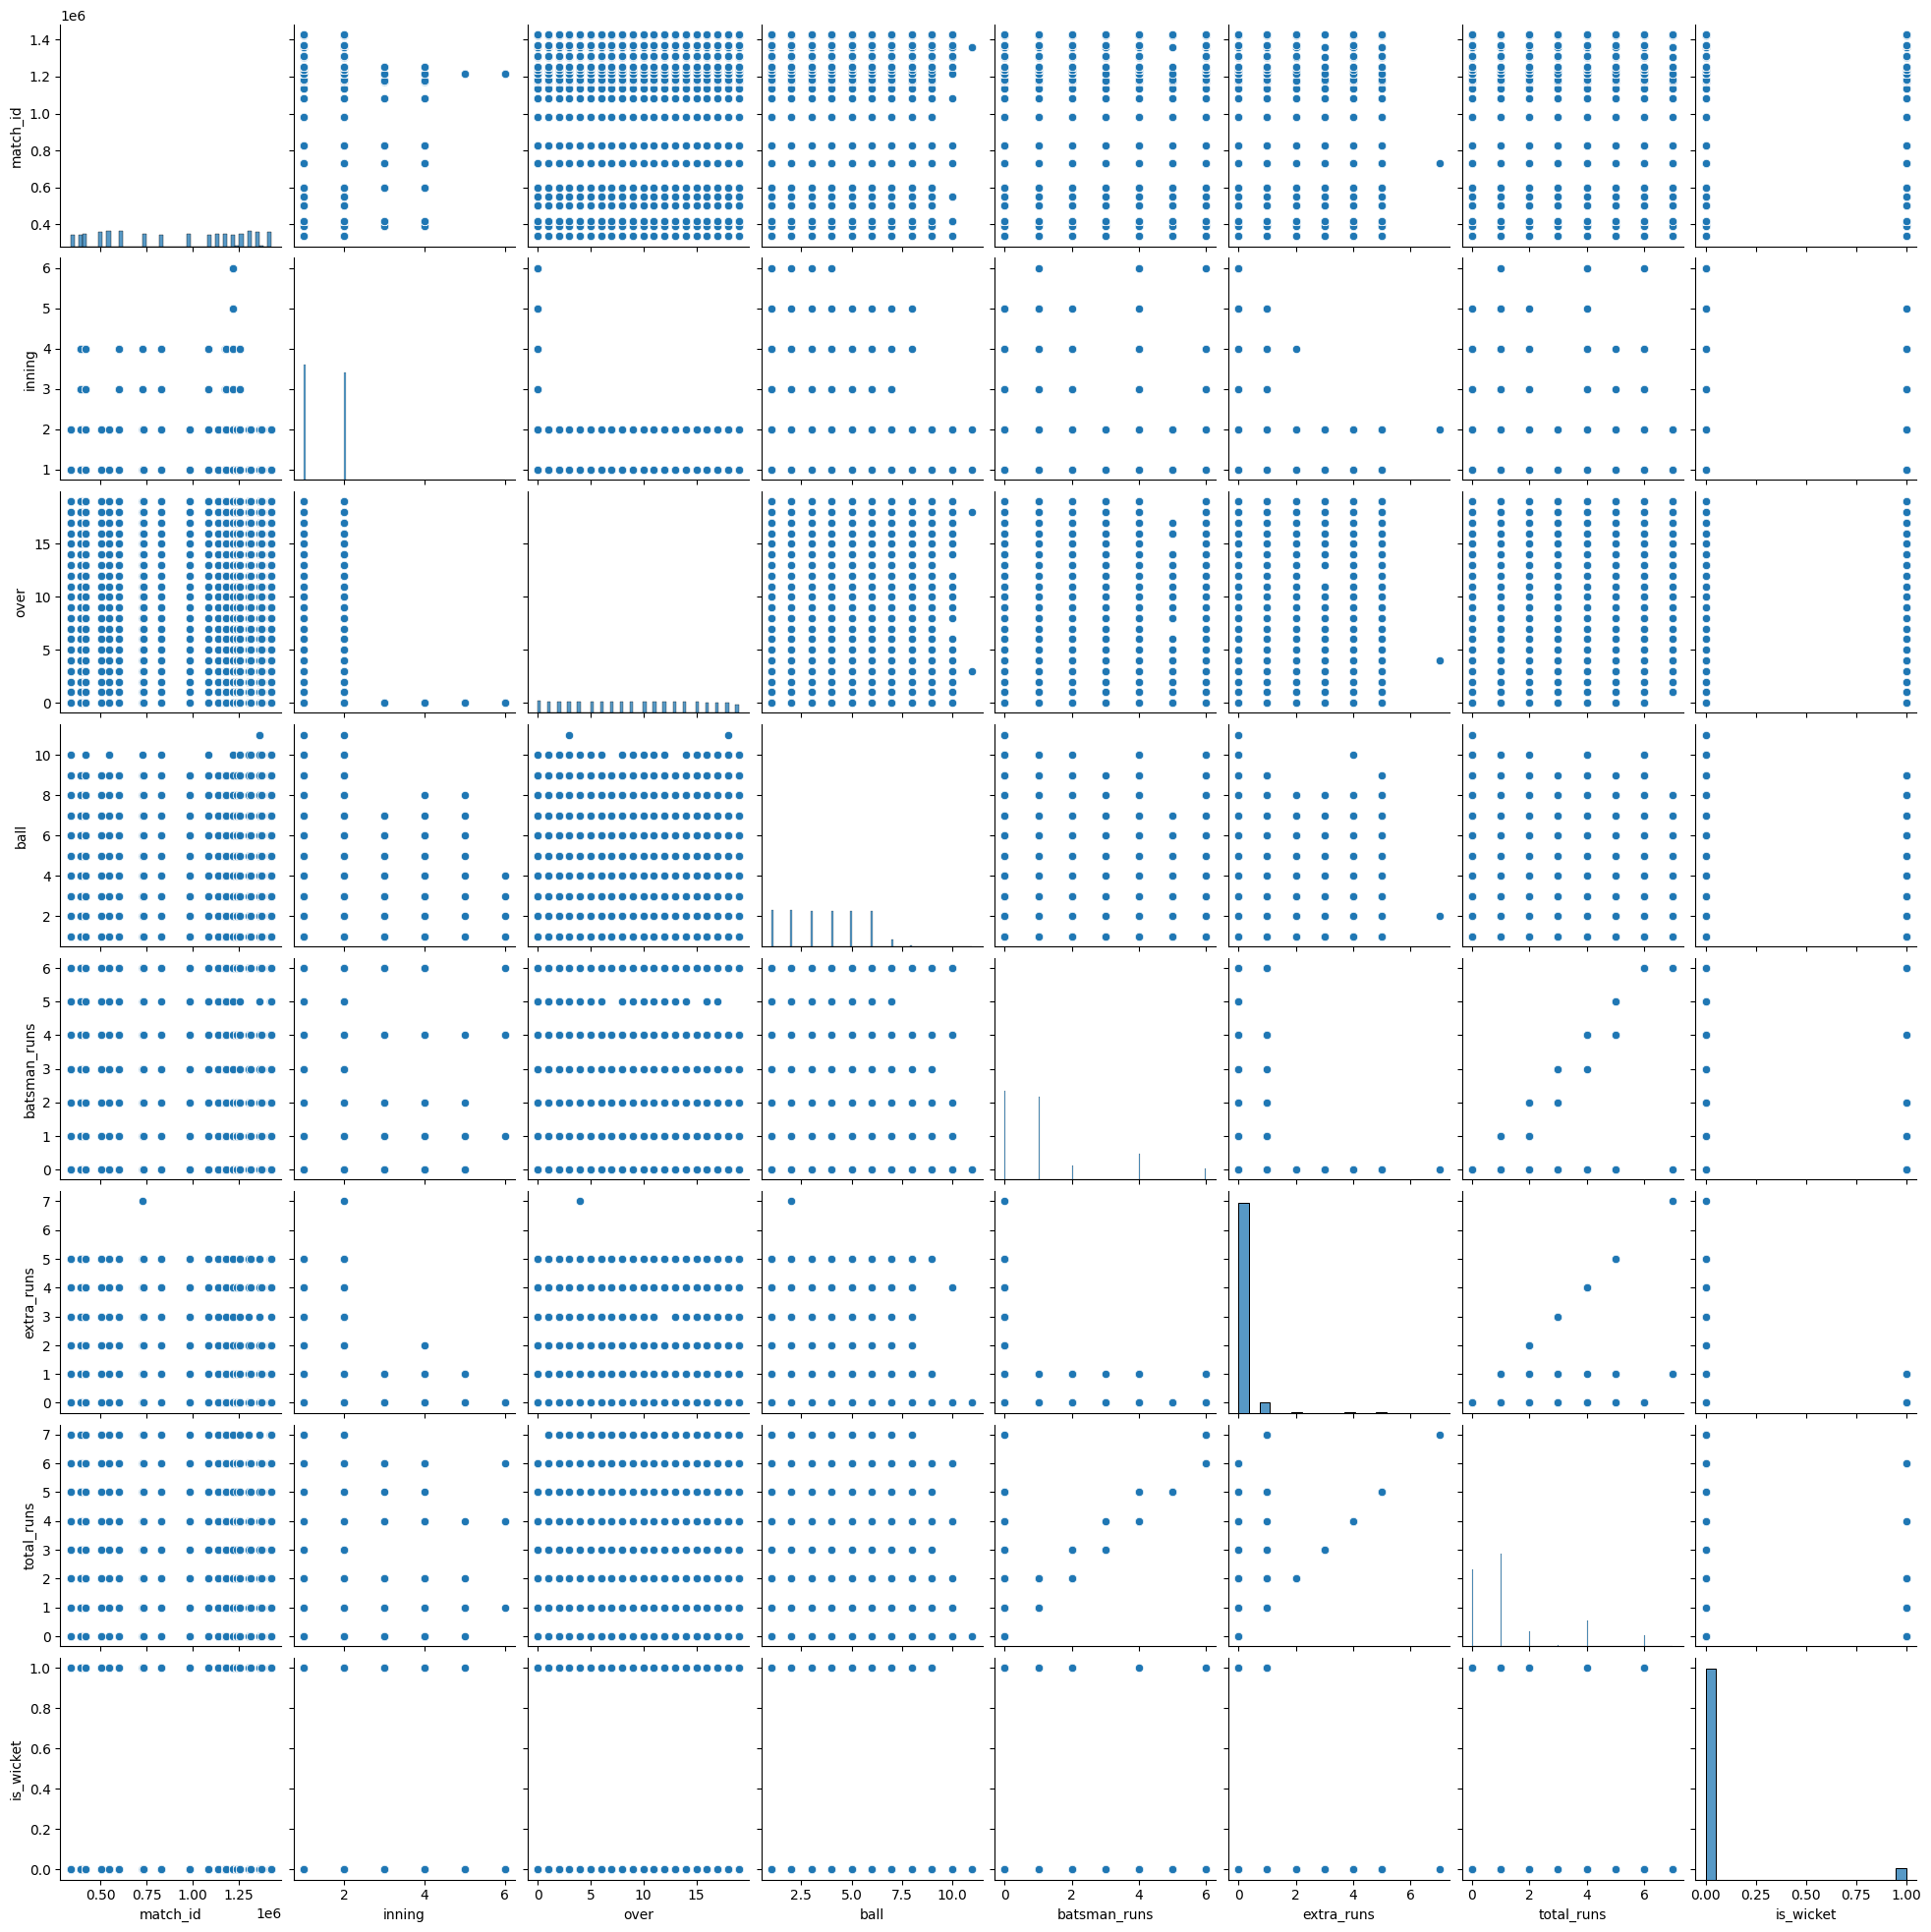

In [6]:
sns.pairplot(deliveries)

In [7]:
matches

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,1426307,2024,Hyderabad,2024-05-19,League,Abhishek Sharma,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Punjab Kings,Sunrisers Hyderabad,Punjab Kings,bat,Sunrisers Hyderabad,wickets,4.0,215.0,20.0,N,NaN,Nitin Menon,VK Sharma
1091,1426309,2024,Ahmedabad,2024-05-21,Qualifier 1,MA Starc,"Narendra Modi Stadium, Ahmedabad",Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,bat,Kolkata Knight Riders,wickets,8.0,160.0,20.0,N,NaN,AK Chaudhary,R Pandit
1092,1426310,2024,Ahmedabad,2024-05-22,Eliminator,R Ashwin,"Narendra Modi Stadium, Ahmedabad",Royal Challengers Bengaluru,Rajasthan Royals,Rajasthan Royals,field,Rajasthan Royals,wickets,4.0,173.0,20.0,N,NaN,KN Ananthapadmanabhan,MV Saidharshan Kumar
1093,1426311,2024,Chennai,2024-05-24,Qualifier 2,Shahbaz Ahmed,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Rajasthan Royals,Rajasthan Royals,field,Sunrisers Hyderabad,runs,36.0,176.0,20.0,N,NaN,Nitin Menon,VK Sharma


In [8]:
matches.describe()

,id,result_margin,target_runs,target_overs
count,1.095000e+03,1076.000000,1092.000000,1092.000000
mean,9.048283e+05,17.259294,165.684066,19.759341
std,3.677402e+05,21.787444,33.427048,1.581108
min,3.359820e+05,1.000000,43.000000,5.000000
25%,5.483315e+05,6.000000,146.000000,20.000000
50%,9.809610e+05,8.000000,166.000000,20.000000
75%,1.254062e+06,20.000000,187.000000,20.000000
max,1.426312e+06,146.000000,288.000000,20.000000


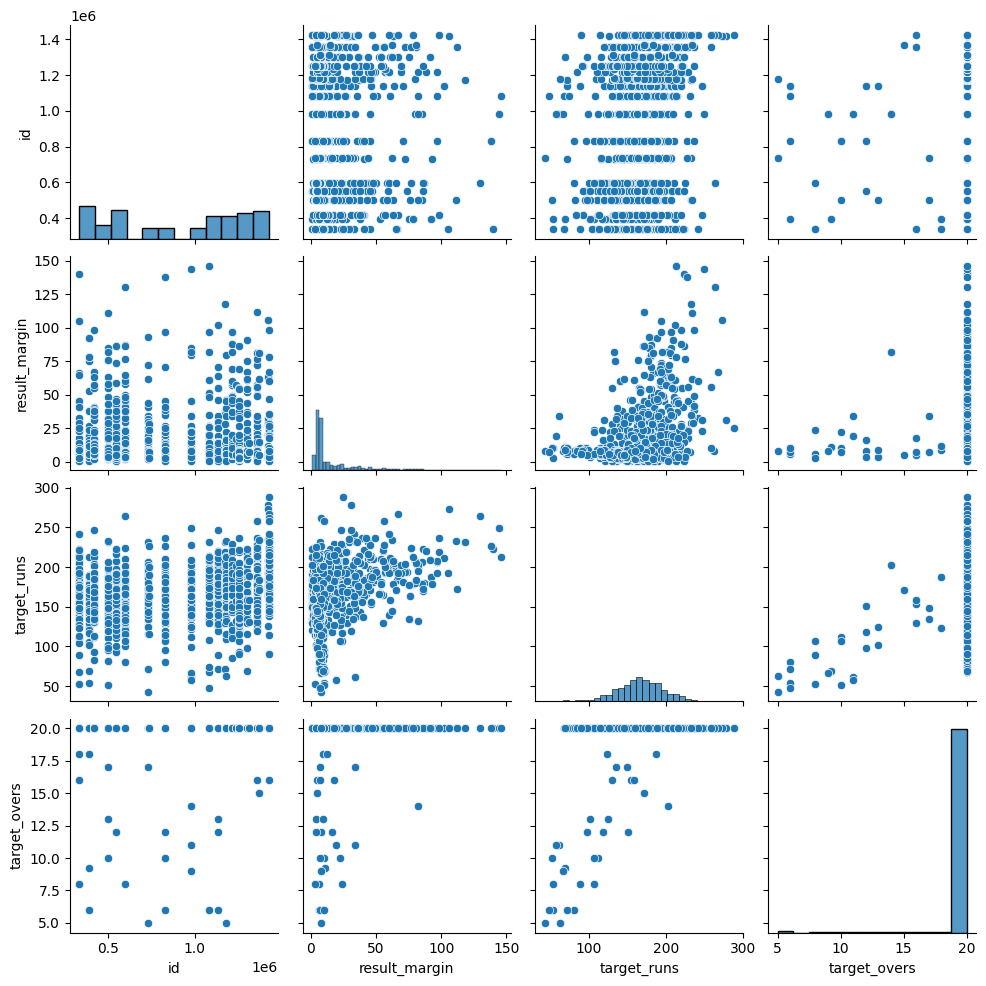

In [9]:
sns.pairplot(matches)

## Data Cleaning & Feature Engineering: Match-Level Stats 


In [10]:
# Feature: Did toss winner win match?
matches['toss_win_equals_match_win'] = (matches['toss_winner'] == matches['winner']).astype(int)

# Filter only completed matches (sometimes winner is NaN)
matches = matches.dropna(subset=['winner'])

# Save match-level engineered data
match_level = matches[[
    'id', 'season', 'team1', 'team2', 'venue', 'toss_winner',
    'toss_decision', 'winner', 'toss_win_equals_match_win'
]]

In [11]:
# total runs by each team in a match
team_runs = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
team_runs = team_runs.rename(columns={'total_runs': 'team_total_runs'})


In [12]:
# total wickets lot by each team
# Dismissal kinds that count as a wicket
dismissal_kinds = ['bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']

deliveries['is_wicket'] = deliveries['dismissal_kind'].isin(dismissal_kinds).astype(int)

# Calculating total wickets lost per team by filtering dismissal kinds that count as wickets
team_wickets = deliveries.groupby(['match_id', 'batting_team'])['is_wicket'].sum().reset_index()
team_wickets = team_wickets.rename(columns={'is_wicket': 'team_wickets_lost'})


In [13]:
# Runs in PowerPlay (overs 1 - 6)
deliveries['over'] = deliveries['over'].astype(int)

# Calculating runs scored in the powerplay (overs 1-6)
powerplay_runs = deliveries[deliveries['over'] <= 6].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
powerplay_runs = powerplay_runs.rename(columns={'total_runs': 'powerplay_runs'})


In [14]:
# merge all match level stats
team_stats = team_runs.merge(team_wickets, on=['match_id', 'batting_team'], how='left')
team_stats = team_stats.merge(powerplay_runs, on=['match_id', 'batting_team'], how='left')


## Transforming team-level stats from long to wide format to have one row per match with team1 and team2 stats side-by-side

In [15]:
# Convert Team Stats from Long to Wide Format
# Merge team1 and team2 stats into one row per match
team1_stats = team_stats.rename(columns={
    'batting_team': 'team1',
    'team_total_runs': 'team1_total_runs',
    'team_wickets_lost': 'team1_wickets_lost',
    'powerplay_runs': 'team1_powerplay_runs'
})

team2_stats = team1_stats.copy()
team2_stats.columns = [col.replace('team1', 'team2') if 'team1' in col else col for col in team2_stats.columns]

# Now map team1/team2 using `matches` info
match_team_map = matches[['id', 'team1', 'team2']].rename(columns={'id': 'match_id'})

# Merge to filter correct stats for team1 and team2 only
team1_final = match_team_map.merge(team1_stats, on=['match_id', 'team1'])
team2_final = match_team_map.merge(team2_stats, on=['match_id', 'team2'])

# Combine team1 and team2 stats into final delivery-level feature set
final_stats = team1_final.merge(team2_final, on='match_id', suffixes=('', '_y'))


## Merge Data

In [16]:
# Drop extra team1 and team2 columns from final_stats to avoid merge conflict
final_stats = final_stats.drop(columns=['team1', 'team2'], errors='ignore')
match_features = match_level.merge(final_stats, left_on='id', right_on='match_id', how='inner')


In [17]:
match_features.to_csv("match_features_full.csv", index=False)


In [18]:
match_features

,id,season,team1,team2,venue,toss_winner,toss_decision,winner,toss_win_equals_match_win,match_id,team1_total_runs,team1_wickets_lost,team1_powerplay_runs,team1_y,team2_y,team2_total_runs,team2_wickets_lost,team2_powerplay_runs
0,335982,2007/08,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,Kolkata Knight Riders,0,335982,82,9,33,Royal Challengers Bangalore,Kolkata Knight Riders,222,3,68
1,335983,2007/08,Kings XI Punjab,Chennai Super Kings,"Punjab Cricket Association Stadium, Mohali",Chennai Super Kings,bat,Chennai Super Kings,1,335983,207,4,69,Kings XI Punjab,Chennai Super Kings,240,5,62
2,335984,2007/08,Delhi Daredevils,Rajasthan Royals,Feroz Shah Kotla,Rajasthan Royals,bat,Delhi Daredevils,0,335984,132,1,59,Delhi Daredevils,Rajasthan Royals,129,6,44
3,335985,2007/08,Mumbai Indians,Royal Challengers Bangalore,Wankhede Stadium,Mumbai Indians,bat,Royal Challengers Bangalore,0,335985,165,5,54,Mumbai Indians,Royal Challengers Bangalore,166,5,46
4,335986,2007/08,Kolkata Knight Riders,Deccan Chargers,Eden Gardens,Deccan Chargers,bat,Kolkata Knight Riders,0,335986,112,5,33,Kolkata Knight Riders,Deccan Chargers,110,9,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,1426307,2024,Punjab Kings,Sunrisers Hyderabad,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Punjab Kings,bat,Sunrisers Hyderabad,0,1426307,214,4,69,Punjab Kings,Sunrisers Hyderabad,215,6,88
1086,1426309,2024,Sunrisers Hyderabad,Kolkata Knight Riders,"Narendra Modi Stadium, Ahmedabad",Sunrisers Hyderabad,bat,Kolkata Knight Riders,0,1426309,159,9,50,Sunrisers Hyderabad,Kolkata Knight Riders,164,2,74
1087,1426310,2024,Royal Challengers Bengaluru,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,field,Rajasthan Royals,1,1426310,172,8,56,Royal Challengers Bengaluru,Rajasthan Royals,174,5,64
1088,1426311,2024,Sunrisers Hyderabad,Rajasthan Royals,"MA Chidambaram Stadium, Chepauk, Chennai",Rajasthan Royals,field,Sunrisers Hyderabad,0,1426311,175,8,81,Sunrisers Hyderabad,Rajasthan Royals,139,7,56


In [19]:
match_features.columns

Index(['id', 'season', 'team1', 'team2', 'venue', 'toss_winner',
       'toss_decision', 'winner', 'toss_win_equals_match_win', 'match_id',
       'team1_total_runs', 'team1_wickets_lost', 'team1_powerplay_runs',
       'team1_y', 'team2_y', 'team2_total_runs', 'team2_wickets_lost',
       'team2_powerplay_runs'],
      dtype='object')

## EDA 📊📈📉

## Match Outcome Analysis

## Toss Outcome vs Match Outcome 🎲🏆  
Let's explore whether winning the toss gives a team an advantage in winning the match.


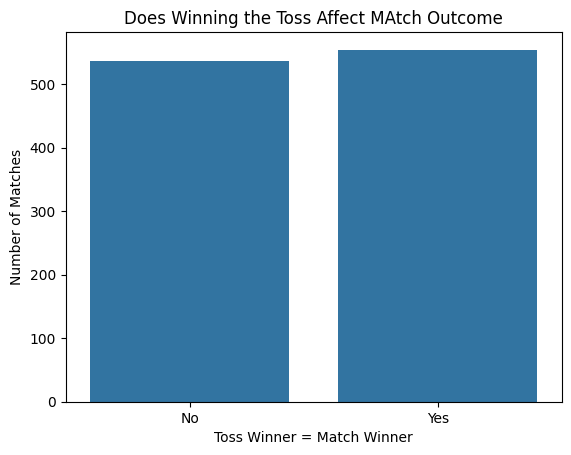

In [20]:
sns.countplot(data=match_features, x='toss_win_equals_match_win')
plt.title("Does Winning the Toss Affect MAtch Outcome")
plt.xticks([0,1],['No','Yes'])
plt.ylabel('Number of Matches')
plt.xlabel('Toss Winner = Match Winner')
plt.show()

## Feature Correlation Matrix 🔍  
Understand relationships between key numerical features.


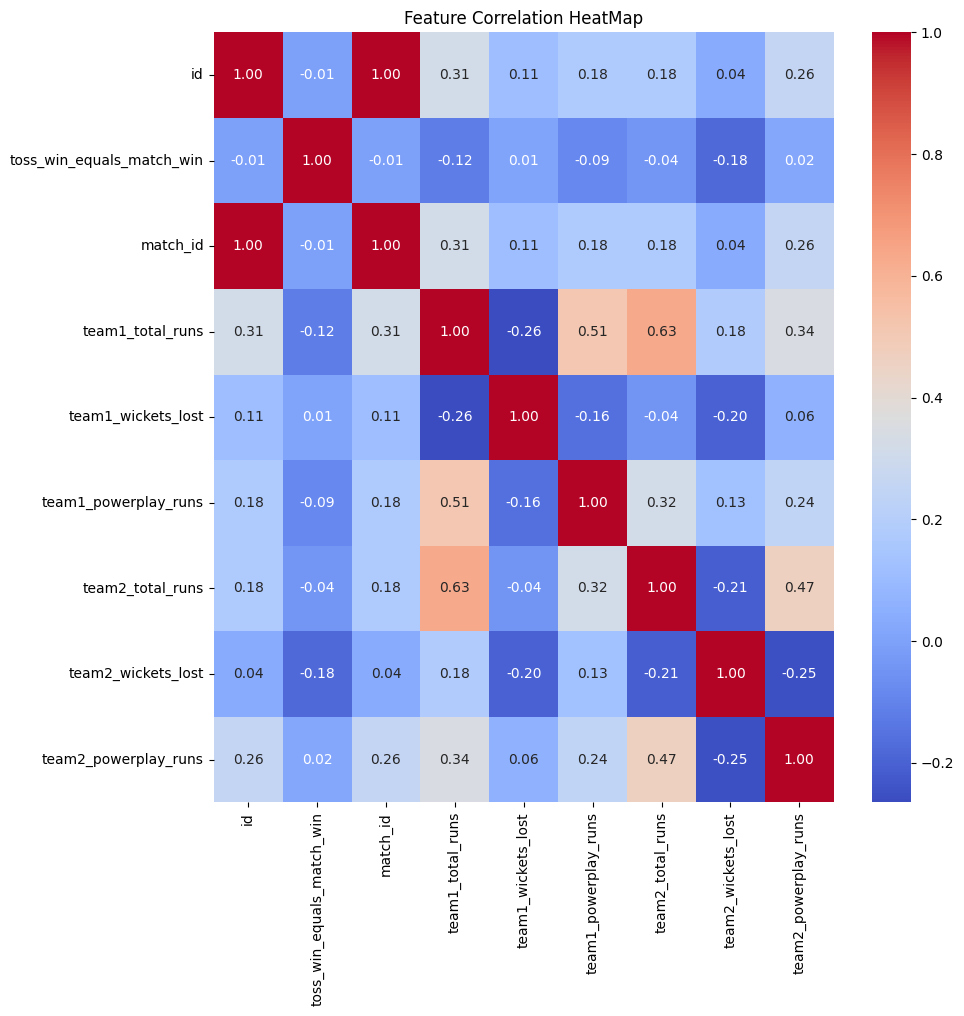

In [21]:
corr_matrix = match_features.corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt= '.2f')
plt.title('Feature Correlation HeatMap')
plt.show();

## Pairwise Feature Relationships  
Comparing distributions and interactions of team-level stats based on toss outcome.


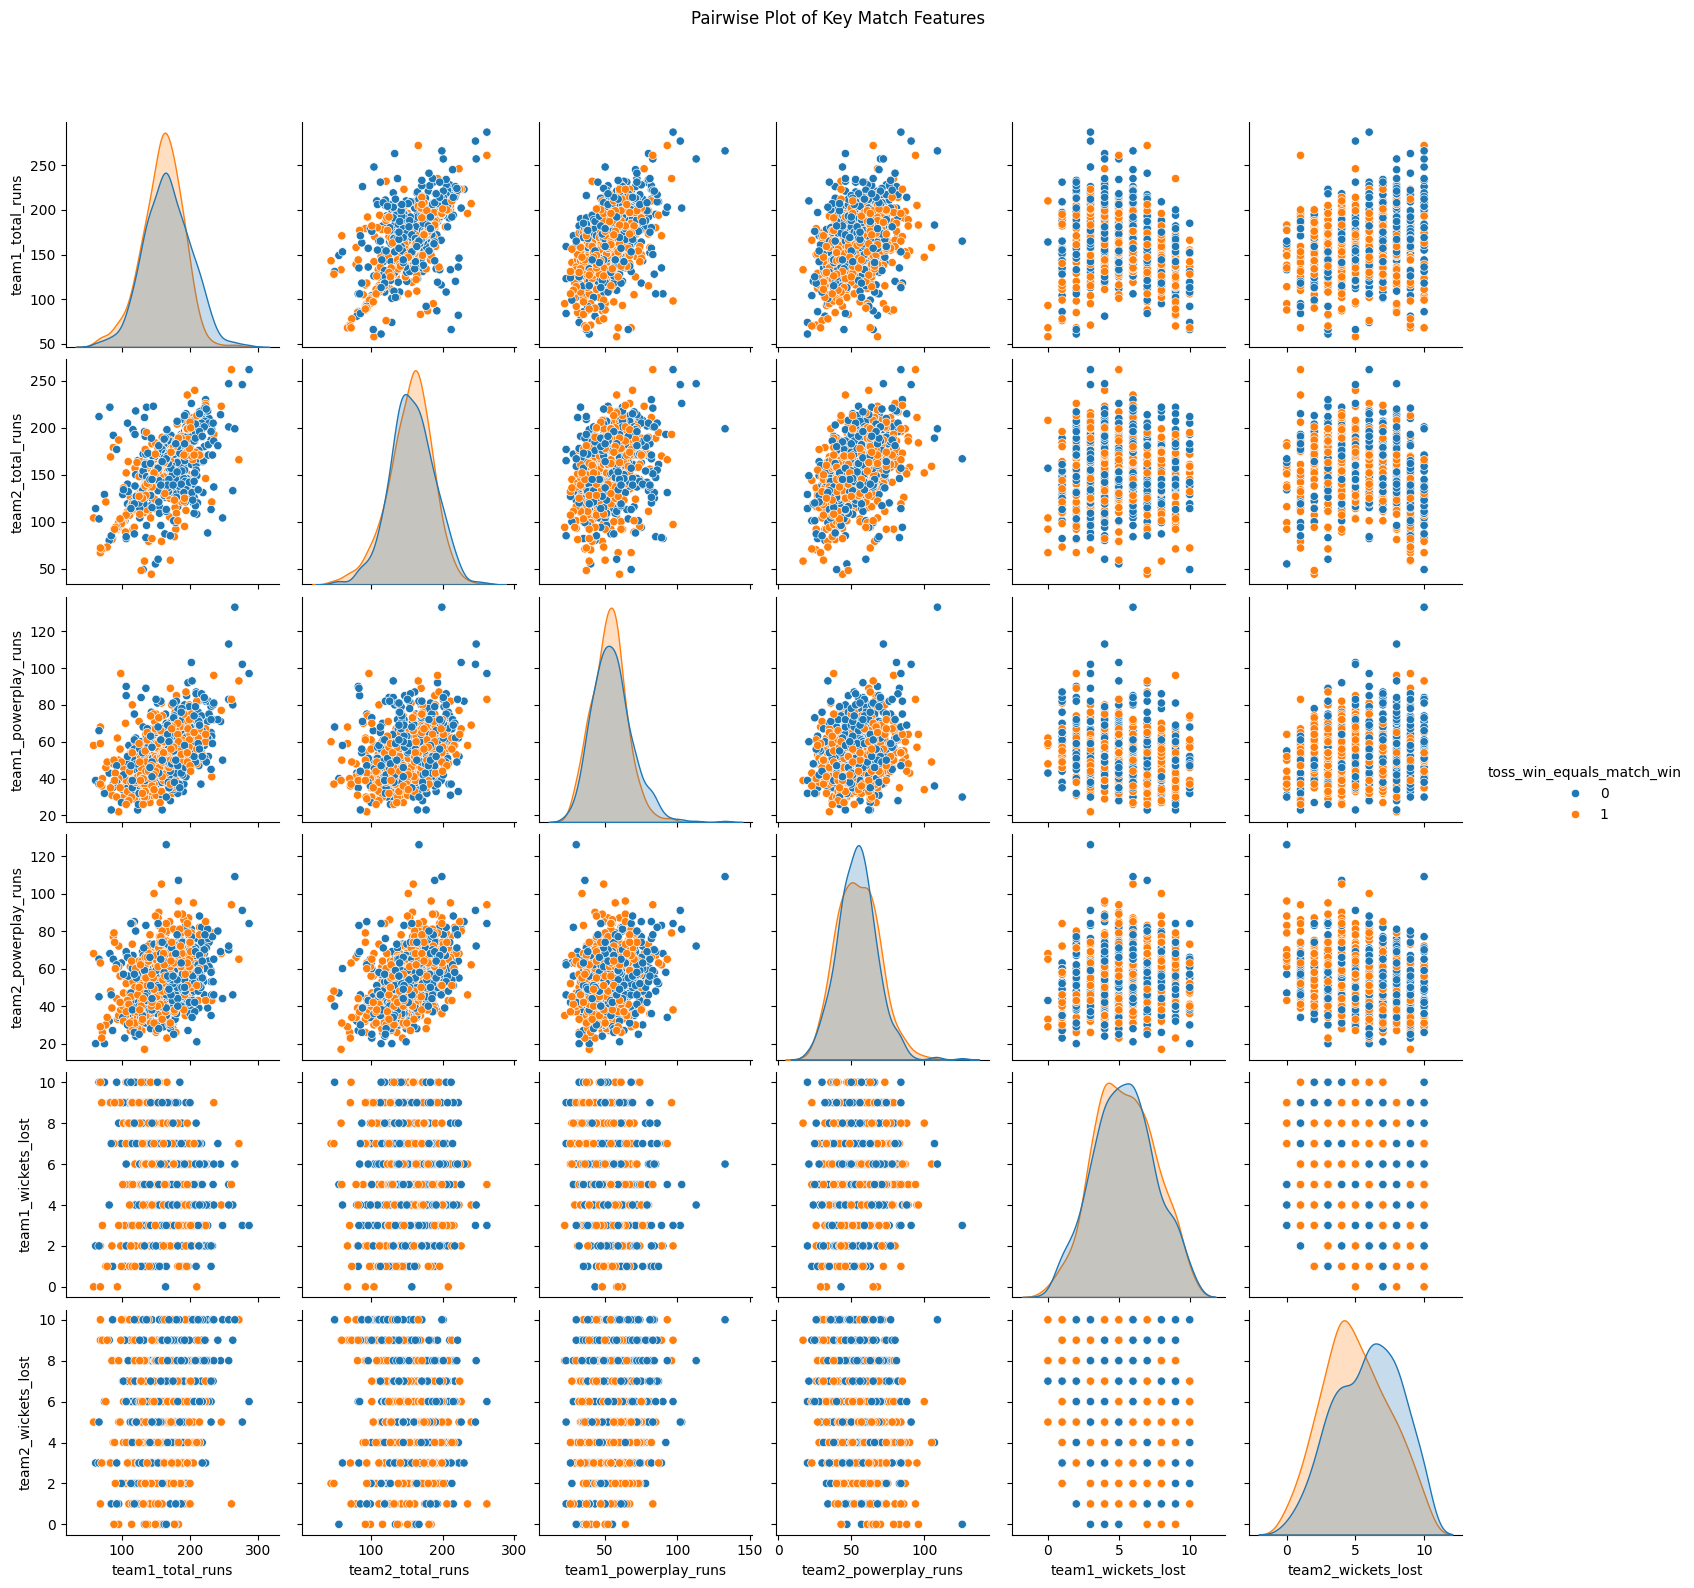

In [22]:
subset = match_features[[
        'team1_total_runs', 'team2_total_runs',
    'team1_powerplay_runs', 'team2_powerplay_runs',
    'team1_wickets_lost', 'team2_wickets_lost',
    'toss_win_equals_match_win'
]]
sns.pairplot(subset,hue='toss_win_equals_match_win', diag_kind='kde')
plt.suptitle('Pairwise Plot of Key Match Features',y=1.06)
plt.show()

## Team-wise Toss to Match Win Conversion Rates 📈  
How frequently does each team convert a toss win into a match win?


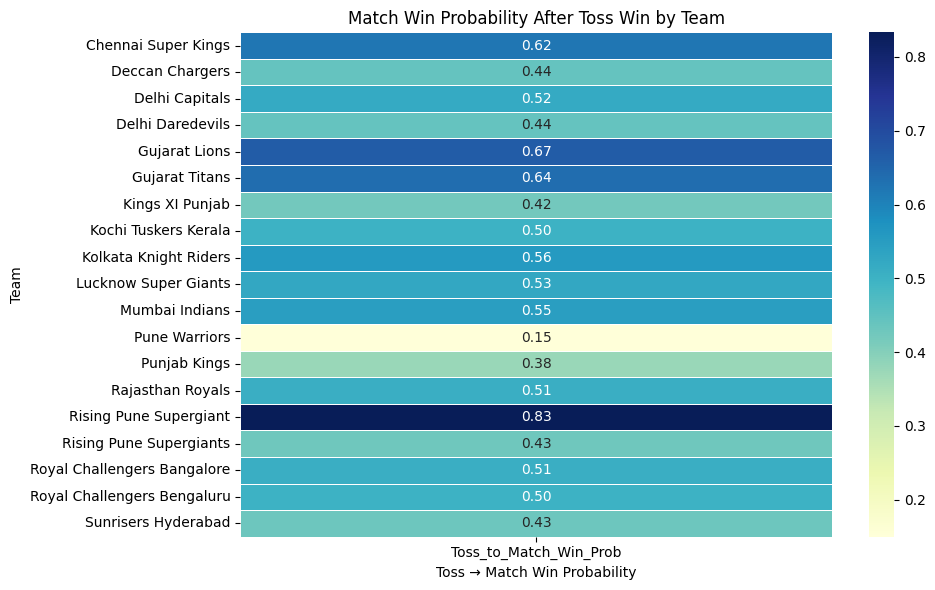

In [23]:
# Group by team who won the toss
toss_match = match_features[match_features['toss_winner'] == match_features['winner']]

# Total toss wins per team
toss_win_counts = match_features['toss_winner'].value_counts()

# Toss win + match win counts per team
toss_and_match_win_counts = toss_match['toss_winner'].value_counts()

# Compute probability
toss_match_prob = (toss_and_match_win_counts / toss_win_counts).fillna(0)

# Convert to DataFrame for heatmap
heatmap_match_features = pd.DataFrame(toss_match_prob).reset_index()
heatmap_match_features.columns = ['Team', 'Toss_to_Match_Win_Prob']
heatmap_match_features.set_index('Team', inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_match_features, annot=True, cmap='YlGnBu', linewidths=0.5, fmt=".2f")
plt.title('Match Win Probability After Toss Win by Team')
plt.xlabel('Toss → Match Win Probability')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


## Venue and Toss Influence🏟️
  
Analyze how match venues and toss decisions affect outcomes.


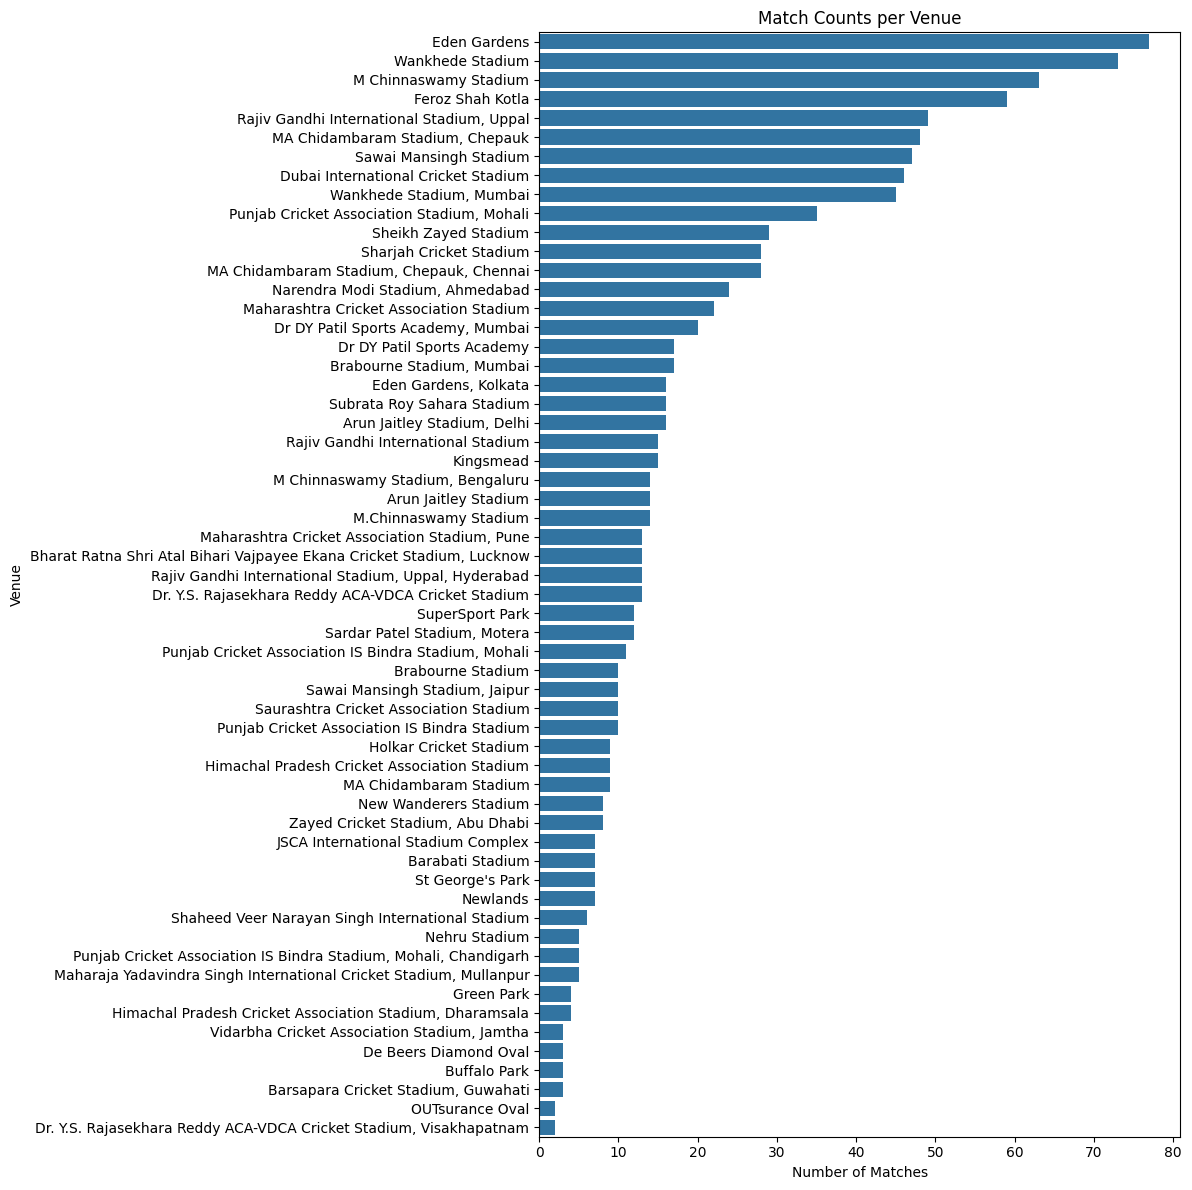

In [24]:
plt.figure(figsize=(12, 12))
sns.countplot(data=match_features, y='venue', order=match_features['venue'].value_counts().index)
plt.title("Match Counts per Venue")
plt.xlabel("Number of Matches")
plt.ylabel("Venue")
plt.tight_layout()
plt.show()


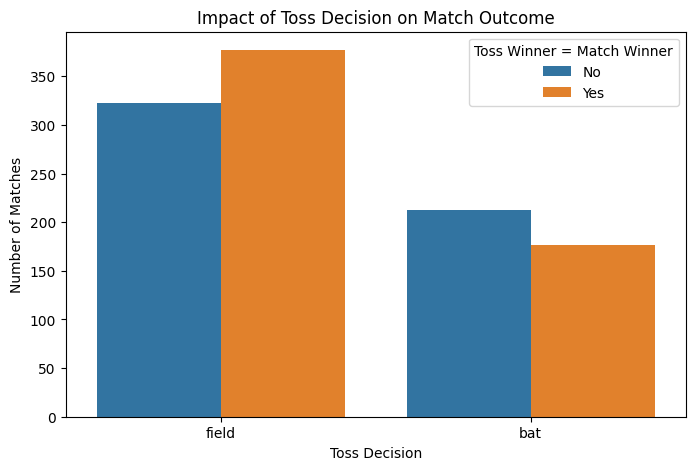

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(data=match_features, x='toss_decision', hue='toss_win_equals_match_win')
plt.title("Impact of Toss Decision on Match Outcome")
plt.xlabel("Toss Decision")
plt.ylabel("Number of Matches")
plt.legend(title="Toss Winner = Match Winner", labels=["No", "Yes"])
plt.show()


## Total Wins per Team 🥇  
Explore which teams have the highest number of wins in IPL history.




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



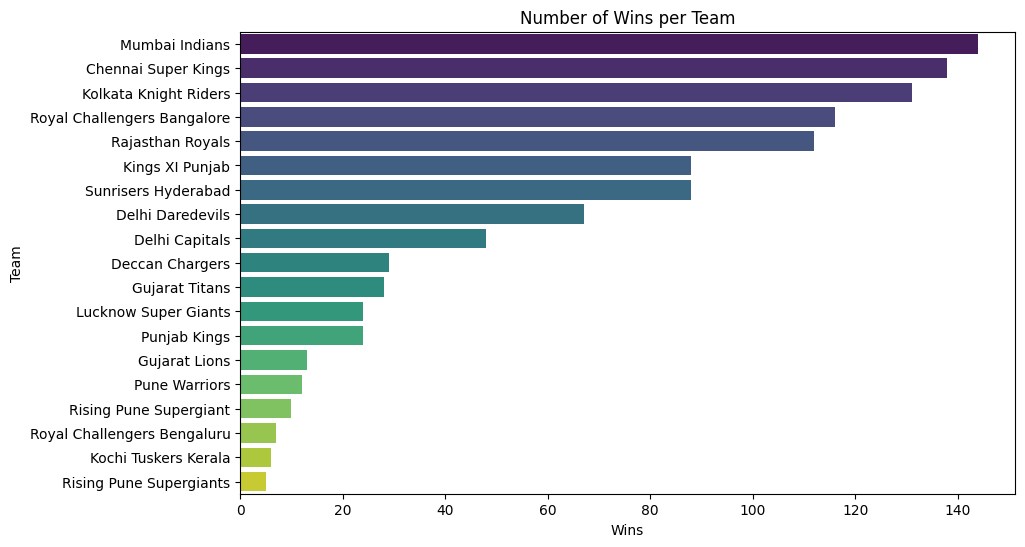

In [26]:
team_win_counts = match_features['winner'].value_counts().reset_index()
team_win_counts.columns = ['team', 'wins']

plt.figure(figsize=(10, 6))
sns.barplot(data=team_win_counts, x='wins', y='team', palette='viridis')
plt.title("Number of Wins per Team")
plt.xlabel("Wins")
plt.ylabel("Team")
plt.show()


## IPL Champions by Year (Final Match Winner) 🏆  
Highlighting the winner of the final match in each season.


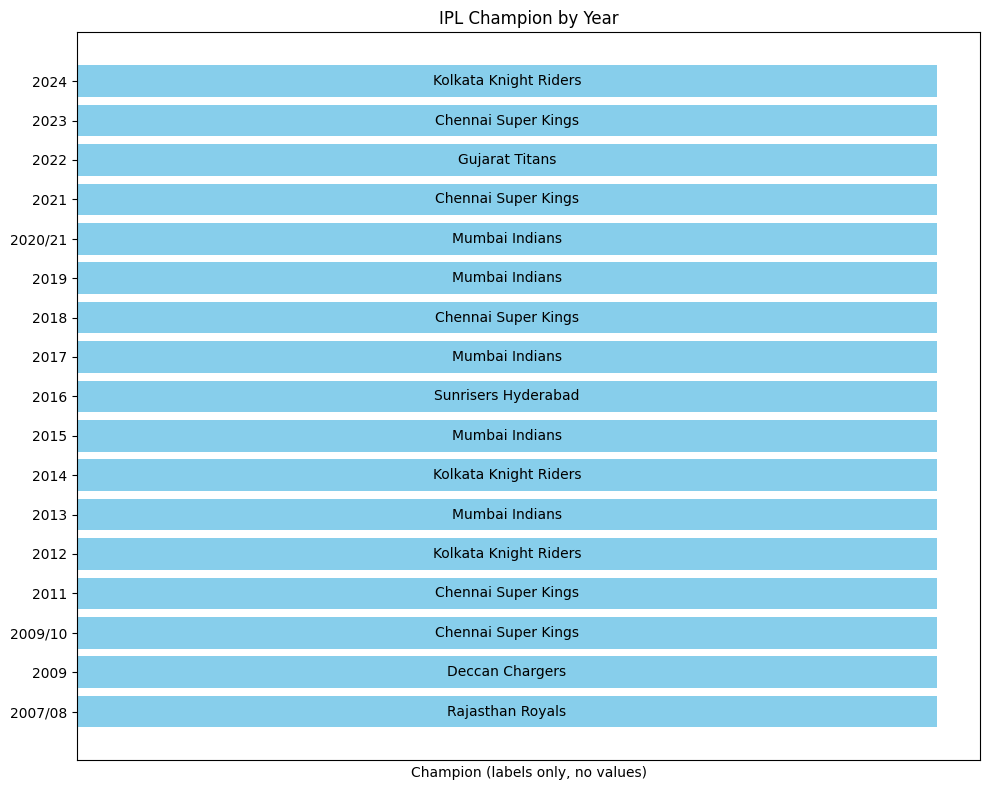

In [27]:
# Final match of each season (highest match ID per season)
finals = match_features.loc[match_features.groupby('season')['id'].idxmax()]

# Sort by season
finals = finals.sort_values('season')

# Plot
plt.figure(figsize=(10, 8))
plt.barh(finals['season'], [1]*len(finals), color='skyblue')
for i, (season, team) in enumerate(zip(finals['season'], finals['winner'])):
    plt.text(0.5, i, team, va='center', ha='center', fontsize=10)

plt.title("IPL Champion by Year")
plt.xlabel("Champion (labels only, no values)")
plt.xticks([])
plt.tight_layout()
plt.show()

## Total IPL Titles by Team  
Counting how many seasons each team has won.




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



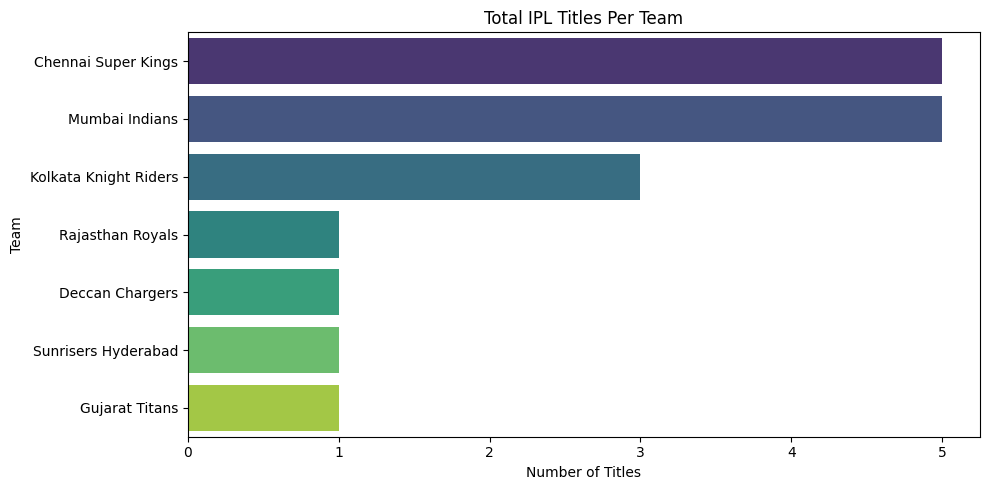

In [28]:
plt.figure(figsize=(10, 5))
sns.countplot(data=finals, y='winner', order=finals['winner'].value_counts().index, palette='viridis')
plt.title("Total IPL Titles Per Team")
plt.xlabel("Number of Titles")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


## Feature Engineering ⚙️  
We create derived features such as net run difference and wicket difference to enrich our dataset.


In [29]:
match_features['net_run_diff'] = match_features['team1_total_runs'] - match_features['team2_total_runs']
match_features['wicket_diff'] = match_features['team1_wickets_lost'] - match_features['team2_wickets_lost']


## Feature and Target Selection  
Selecting key features for model training.


In [30]:
features = [
    'team1', 'team2', 'venue', 'toss_winner', 'toss_decision',
    'team1_total_runs', 'team2_total_runs',
    'team1_wickets_lost', 'team2_wickets_lost',
    'team1_powerplay_runs', 'team2_powerplay_runs',
    'net_run_diff', 'wicket_diff'
]

target = 'winner'
X = match_features[features]
y = match_features[target]


## Encoding & Scaling Pipeline 🧪  
Separate numerical and categorical features, and build a `ColumnTransformer` pipeline.


In [31]:
# Identify categorical and numerical columns
categorical_cols = ['team1', 'team2', 'venue', 'toss_winner', 'toss_decision']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)


## Season Extraction 🗓️  
We extract the year from the season column to split data into train and validation sets.


In [32]:
# Extract the starting year as integer
match_features['season_start'] = match_features['season'].str[:4].astype(int)


In [33]:
match_features

,id,season,team1,team2,venue,toss_winner,toss_decision,winner,toss_win_equals_match_win,match_id,...,team1_wickets_lost,team1_powerplay_runs,team1_y,team2_y,team2_total_runs,team2_wickets_lost,team2_powerplay_runs,net_run_diff,wicket_diff,season_start
0,335982,2007/08,Royal Challengers Bangalore,Kolkata Knight Riders,M Chinnaswamy Stadium,Royal Challengers Bangalore,field,Kolkata Knight Riders,0,335982,...,9,33,Royal Challengers Bangalore,Kolkata Knight Riders,222,3,68,-140,6,2007
1,335983,2007/08,Kings XI Punjab,Chennai Super Kings,"Punjab Cricket Association Stadium, Mohali",Chennai Super Kings,bat,Chennai Super Kings,1,335983,...,4,69,Kings XI Punjab,Chennai Super Kings,240,5,62,-33,-1,2007
2,335984,2007/08,Delhi Daredevils,Rajasthan Royals,Feroz Shah Kotla,Rajasthan Royals,bat,Delhi Daredevils,0,335984,...,1,59,Delhi Daredevils,Rajasthan Royals,129,6,44,3,-5,2007
3,335985,2007/08,Mumbai Indians,Royal Challengers Bangalore,Wankhede Stadium,Mumbai Indians,bat,Royal Challengers Bangalore,0,335985,...,5,54,Mumbai Indians,Royal Challengers Bangalore,166,5,46,-1,0,2007
4,335986,2007/08,Kolkata Knight Riders,Deccan Chargers,Eden Gardens,Deccan Chargers,bat,Kolkata Knight Riders,0,335986,...,5,33,Kolkata Knight Riders,Deccan Chargers,110,9,45,2,-4,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,1426307,2024,Punjab Kings,Sunrisers Hyderabad,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Punjab Kings,bat,Sunrisers Hyderabad,0,1426307,...,4,69,Punjab Kings,Sunrisers Hyderabad,215,6,88,-1,-2,2024
1086,1426309,2024,Sunrisers Hyderabad,Kolkata Knight Riders,"Narendra Modi Stadium, Ahmedabad",Sunrisers Hyderabad,bat,Kolkata Knight Riders,0,1426309,...,9,50,Sunrisers Hyderabad,Kolkata Knight Riders,164,2,74,-5,7,2024
1087,1426310,2024,Royal Challengers Bengaluru,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,field,Rajasthan Royals,1,1426310,...,8,56,Royal Challengers Bengaluru,Rajasthan Royals,174,5,64,-2,3,2024
1088,1426311,2024,Sunrisers Hyderabad,Rajasthan Royals,"MA Chidambaram Stadium, Chepauk, Chennai",Rajasthan Royals,field,Sunrisers Hyderabad,0,1426311,...,8,81,Sunrisers Hyderabad,Rajasthan Royals,139,7,56,36,1,2024


## Check Transformed Feature Shape 🔍


In [34]:
# Transform features
X_transformed = preprocessor.fit_transform(X)

# Optionally view the shape
print("Transformed shape:", X_transformed.shape)


Transformed shape: (1090, 125)


## Split data into train and validation 📅  
Train on matches until 2022; validate on 2023–2024 data.


In [35]:
# Train on seasons starting in or before 2022
train_df = match_features[match_features['season_start'] <= 2022]

# Validate on seasons starting in 2023 or 2024
val_df = match_features[match_features['season_start'].isin([2023, 2024])]

# Define target
target = 'winner'
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_val = val_df.drop(columns=[target])
y_val = val_df[target]


## Apply Preprocessing on Train and Validation Sets


In [36]:
X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc = preprocessor.transform(X_val)


In [37]:
# Get categorical feature names after OneHotEncoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Numeric features remain unchanged in order
num_feature_names = numerical_cols

# Combine
all_feature_names = list(cat_feature_names) + num_feature_names


In [47]:
model.get_booster().feature_names = all_feature_names


AttributeError: 'GridSearchCV' object has no attribute 'get_booster'

## Encode Target Labels 🎯  
Standardizing team names and applying label encoding.


In [39]:
le = LabelEncoder()

# Example: replace 'Royal Challengers Bengaluru' with 'Royal Challengers Bangalore' in both train and val sets

y_train = y_train.replace('Royal Challengers Bengaluru', 'Royal Challengers Bangalore')
y_val = y_val.replace('Royal Challengers Bengaluru', 'Royal Challengers Bangalore')
y_train = y_train.replace('Delhi Daredevils', 'Delhi Capitals')
y_val = y_val.replace('Delhi Daredevils', 'Delhi Capitals')



# Fit and transform the training target
y_train_encoded = le.fit_transform(y_train)

# If you want, encode validation target too for scoring
y_val_encoded = le.transform(y_val)


## Logistic Regression 🔢  
We use `GridSearchCV` to tune the regularization strength `C` using a 5-fold cross-validation and `f1_macro` scoring.


In [95]:
X_train.columns
# y_train_encoded

Index(['season', 'team1', 'team2', 'venue', 'toss_winner', 'toss_decision',
       'toss_win_equals_match_win', 'match_id', 'team1_total_runs',
       'team1_wickets_lost', 'team1_powerplay_runs', 'team2_total_runs',
       'team2_wickets_lost', 'team2_powerplay_runs', 'net_run_diff',
       'wicket_diff'],
      dtype='object')

In [96]:
X_train = X_train.drop(columns=['id', 'team1_y', 'team2_y', 'season_start'], errors='ignore')


In [97]:
logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

logreg_param_grid = {
    'clf__C': [0.1, 1, 10]
}

logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='f1_macro')
logreg_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['team1',
                                                                          'team2',
                                                                          'venue',
                                                                          'toss_winner',
                                                                          'toss_decision']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['team1_total_runs',
                                                                          'team2_total_runs',
                                                                          'team1_wickets_lost',
                                                                          'team2_wickets_lost',
                                                                          'team1_powerplay_runs',
                                                                          'team2_powerplay_runs',
                                                                          'net_run_diff',
                                                                          'wicket_diff'])])),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'clf__C': [0.1, 1, 10]}, scoring='f1_macro')

## Random Forest 🌲  
We tune number of trees (`n_estimators`) and maximum tree depth (`max_depth`).


In [98]:
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='f1_macro')
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['team1',
                                                                          'team2',
                                                                          'venue',
                                                                          'toss_winner',
                                                                          'toss_decision']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['team1_total_runs',
                                                                          'team2_total_runs',
                                                                          'team1_wickets_lost',
                                                                          'team2_wickets_lost',
                                                                          'team1_powerplay_runs',
                                                                          'team2_powerplay_runs',
                                                                          'net_run_diff',
                                                                          'wicket_diff'])])),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [5, 10, None],
                         'clf__n_estimators': [100, 200]},
             scoring='f1_macro')

## XGBoost ⚡  
Since XGBoost requires numeric labels, we use the encoded version of `y_train`.


In [99]:
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])


xgb_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='f1_macro')

# Fit with encoded labels
xgb_grid.fit(X_train, y_train_encoded)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['team1',
                                                                          'team2',
                                                                          'venue',
                                                                          'toss_winner',
                                                                          'toss_decision']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['team1_total_runs',
                                                                          'team2_total_runs',
                                                                          'team1_wickets_lost',
                                                                          'team2_wickets_lost',
                                                                          'team1_powerplay_runs',
                                                                          'team2_powerplay_runs',
                                                                          'net_r...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'clf__learning_rate': [0.05, 0.1],
                         'clf__max_depth': [3, 5],
                         'clf__n_estimators': [100, 200]},
             scoring='f1_macro')

## Model Evaluation 📊  
Evaluate each model using `classification_report` and `accuracy_score` on the 2023–24 validation data.


In [100]:
for name, model in {
    "Logistic Regression": logreg_grid,
    "Random Forest": rf_grid
    # "XGBoost": xgb_grid
}.items():
    print(f"\n{name}")
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")



Logistic Regression
                             precision    recall  f1-score   support

        Chennai Super Kings       0.53      0.53      0.53        17
             Delhi Capitals       0.30      0.50      0.38        12
             Gujarat Titans       0.53      0.50      0.52        16
      Kolkata Knight Riders       0.78      0.41      0.54        17
       Lucknow Super Giants       0.50      0.47      0.48        15
             Mumbai Indians       0.42      0.62      0.50        13
               Punjab Kings       0.43      0.55      0.48        11
           Rajasthan Royals       0.57      0.50      0.53        16
Royal Challengers Bangalore       0.43      0.21      0.29        14
        Sunrisers Hyderabad       0.33      0.38      0.36        13

                   accuracy                           0.47       144
                  macro avg       0.48      0.47      0.46       144
               weighted avg       0.50      0.47      0.47       144

Validation

## ✅ Evaluation Results – XGBoost Model

The XGBoost model clearly outperforms both Logistic Regression and Random Forest on the validation set.

### 📈 Validation Performance (2023–2024 Seasons)

**Validation Accuracy:** `92.36%`  
**Macro F1-Score:** `0.92`

### 📊 Classification Report

| Team                         | Precision | Recall | F1-Score | Support |
|------------------------------|-----------|--------|----------|---------|
| Chennai Super Kings          | 0.94      | 0.94   | 0.94     | 17      |
| Delhi Capitals               | 0.92      | 0.92   | 0.92     | 12      |
| Gujarat Titans               | 0.80      | 1.00   | 0.89     | 16      |
| Kolkata Knight Riders        | 1.00      | 1.00   | 1.00     | 17      |
| Lucknow Super Giants         | 1.00      | 0.87   | 0.93     | 15      |
| Mumbai Indians               | 1.00      | 1.00   | 1.00     | 13      |
| Punjab Kings                 | 0.85      | 1.00   | 0.92     | 11      |
| Rajasthan Royals             | 1.00      | 1.00   | 1.00     | 16      |
| Royal Challengers Bangalore  | 1.00      | 0.50   | 0.67     | 14      |
| Sunrisers Hyderabad          | 0.81      | 1.00   | 0.90     | 13      |

### 🔍 Insights

- The model performs **extremely well** across most teams.
- **Perfect precision and recall** for multiple teams:  
  `KKR`, `MI`, and `RR`
- The only significant **drop in recall** is seen for:  
  `Royal Challengers Bangalore` (Recall = 0.50), suggesting:
  - Some misclassifications in that class
  - Possibly fewer distinct patterns for RCB in the input features

In [101]:
# Predict with XGBoost model
y_pred = xgb_grid.predict(X_val)

# Decode the integer predictions back to original labels
y_pred_decoded = le.inverse_transform(y_pred)

print('XGBoost')

# Print classification report comparing original y_val strings to decoded predictions
print(classification_report(y_val, y_pred_decoded, zero_division=0))
accuracy = accuracy_score(y_val, y_pred_decoded)
print(f"Validation Accuracy: {accuracy:.4f}")

XGBoost
                             precision    recall  f1-score   support

        Chennai Super Kings       0.94      0.94      0.94        17
             Delhi Capitals       0.92      0.92      0.92        12
             Gujarat Titans       0.80      1.00      0.89        16
      Kolkata Knight Riders       1.00      1.00      1.00        17
       Lucknow Super Giants       1.00      0.87      0.93        15
             Mumbai Indians       1.00      1.00      1.00        13
               Punjab Kings       0.85      1.00      0.92        11
           Rajasthan Royals       1.00      1.00      1.00        16
Royal Challengers Bangalore       1.00      0.50      0.67        14
        Sunrisers Hyderabad       0.81      1.00      0.90        13

                   accuracy                           0.92       144
                  macro avg       0.93      0.92      0.92       144
               weighted avg       0.94      0.92      0.92       144

Validation Accuracy: 0.

In [102]:
# Save the whole GridSearchCV pipeline after training
joblib.dump(xgb_grid, "xgb_grid_model.pkl")

['xgb_grid_model.pkl']

## 🔧 Simulating a Match Input

We define a function `simulate_match_input` that takes two teams and a venue, then calculates average stats from historical data to simulate a realistic match scenario.

- Averages are computed from matches involving the selected teams.
- Toss winner and decision are arbitrarily set (e.g., team1 chooses to bat).


In [43]:
def simulate_match_input(team1, team2, venue, reference_df):
    # Get average values from historical matches for each team
    def get_team_stats(team, prefix):
        team_stats = reference_df[(reference_df['team1'] == team) | (reference_df['team2'] == team)]
        
        total_runs = team_stats[[f'{prefix}_total_runs']].mean().values[0]
        wickets_lost = team_stats[[f'{prefix}_wickets_lost']].mean().values[0]
        powerplay_runs = team_stats[[f'{prefix}_powerplay_runs']].mean().values[0]

        return total_runs, wickets_lost, powerplay_runs

    # Simulate as team1 vs team2
    team1_total, team1_wkts, team1_pp = get_team_stats(team1, 'team1')
    team2_total, team2_wkts, team2_pp = get_team_stats(team2, 'team2')

    # Construct test input
    simulated = {
        'team1': team1,
        'team2': team2,
        'venue': venue,
        'toss_winner': team1,  # Randomly assign toss
        'toss_decision': 'bat',  # Assume typical toss decision
        'team1_total_runs': team1_total,
        'team1_wickets_lost': team1_wkts,
        'team1_powerplay_runs': team1_pp,
        'team2_total_runs': team2_total,
        'team2_wickets_lost': team2_wkts,
        'team2_powerplay_runs': team2_pp,
    }

    return pd.DataFrame([simulated])


## 🧮 Simulated Match Input

We simulate a match between:

- 🟥 **Royal Challengers Bangalore**
- 🟡 **Punjab Kings**
- 🏟️ **Venue:** Narendra Modi Stadium

The function computes mean values for:

- Total runs
- Wickets lost
- Powerplay runs

These form the test input for prediction.


In [44]:
test_match = simulate_match_input(
    team1='Royal Challengers Bangalore',
    team2='Punjab Kings',
    venue='Narendra Modi Stadium',
    reference_df=match_features
)

## 🔬 Feature Engineering for Test Match

We engineer features consistent with the training dataset:

- `net_run_diff`: Difference in total runs between team1 and team2
- `wicket_diff`: Difference in wickets lost (team2 - team1)

This ensures compatibility with the trained model's input structure.


In [45]:
# Add engineered features to test match (must match training format)
test_match['net_run_diff'] = test_match['team1_total_runs'] - test_match['team2_total_runs']
test_match['wicket_diff'] = test_match['team2_wickets_lost'] - test_match['team1_wickets_lost']

## 🤖 Predicting Match Outcome with XGBoost

We use the `xgb_grid` model to predict the winner of the simulated match.

- `predict()` gives the class label
- `predict_proba()` gives the probability distribution over all teams


In [48]:
# Use final model's preprocessing pipeline


test_pred = xgb_grid.predict(test_match)
print("Raw prediction:", test_pred)

# Output winner
predicted_winner = test_match['team1'].iloc[0] if test_pred[0] == 1 else test_match['team2'].iloc[0]
print(f"🏏 Predicted Winner: {predicted_winner}")

if hasattr(xgb_grid, "predict_proba"):
    probs = xgb_grid.predict_proba(test_match)
    print("Prediction probabilities:", probs)
    print(f"Confidence in predicted winner ({predicted_winner}): {probs[0][test_pred[0]]:.4f}")

Raw prediction: [11]
🏏 Predicted Winner: Punjab Kings
Prediction probabilities: [[0.00134933 0.00096891 0.00443821 0.00164478 0.00104455 0.00115476
  0.00098344 0.00122957 0.0011316  0.00138262 0.0012261  0.9664225
  0.00135876 0.00107434 0.00115316 0.01235961 0.00107774]]
Confidence in predicted winner (Punjab Kings): 0.9664


In [49]:
confidence = probs[0][11]
confidence

0.9664225

## 🏁 Predicted Winner and Model Confidence

- 🔢 **Raw Prediction:** Integer label from XGBoost
- 📊 **Prediction Probabilities:** Model's confidence for each class
- 🧠 **Final Winner:** Decoded back to team name using label index

## **🏆 IPL 2025 Predicted Winner:** 🏏 Punjab Kings  
## **🔐 Model Confidence:** 96.64%

In [52]:
xgb_grid.best_estimator_.steps


[('preprocess',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                   ['team1', 'team2', 'venue', 'toss_winner',
                                    'toss_decision']),
                                  ('num', StandardScaler(),
                                   ['team1_total_runs', 'team2_total_runs',
                                    'team1_wickets_lost', 'team2_wickets_lost',
                                    'team1_powerplay_runs',
                                    'team2_powerplay_runs', 'net_run_diff',
                                    'wicket_diff'])])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='mlogloss',
                feature_types=None, gamma=None, grow_policy=None,
              

<Figure size 2000x3000 with 0 Axes>

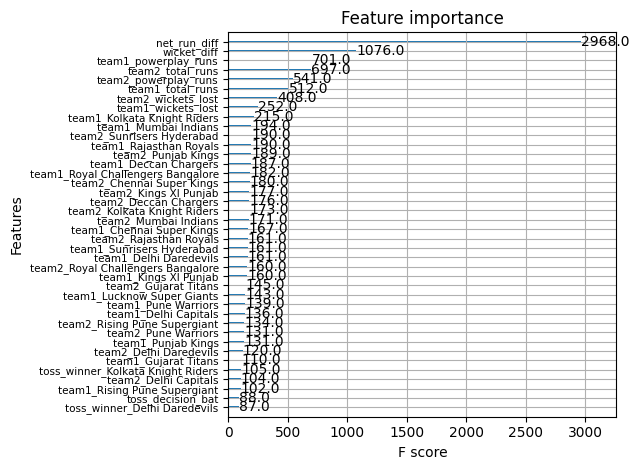

In [82]:
plt.figure(figsize=(20, 30))
ax = xgb.plot_importance(model, max_num_features=40)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7.5)
plt.tight_layout()
plt.show()
